My notes from working through [Practical statistics for data science](https://learning.oreilly.com/library/view/practical-statistics-for/9781492072935/)

Terminology:
- Stochastic is a synonym for random. A stochastic process is a random process. The distinction between *stochastics* and *statistics* is that a stochastic processes generate the data we analyse in statistics.

Sampling:

- We rely on a sample to learn about a larger population.
- We thus need to make sure that the sampling procedure is free of bias, so that units in the sample are representative of those in the population.
- While representativeness cannot be achieved perfectly, it's important to ensure that non-representativeness is due to random error and not due to systematic bias.
- Random errors produces deviations that vary over repeated samples, while systematic bias persists. Such selection bias can lead to misleading and ephemeral conclusions.
- Two basic sampling procedures are simple random sampling (randomly select $n$ units from a population of $N$) and stratified random sampling (randomly select $n_s$ from each stratum $S$ of a population of $N$).
- The mean outcome of the population is denoted $\bar{x}$, that of the population $\mu$.
- Using the data to answer many questions will eventually reveal something interesting by mere chance (if 20,000 people flip a coin 10 times, some will have 10 straight heads). This is sometimes called the Vast Search Effect.
- Common types of selection bias in data science:
    - The vast search effect
    - Nonrandom sampling
    - Cherry-picking data
    - Selecting specific time-intervals
    - Stopping experiments prematurely
- Ways to guard against selection bias: have one or many holdout datasets to confirm your results.
- Regression to the mean results form a particular kind of selection bias in a setting we measure outcomes repeatedly over time: when luck and skill combine to determine outcomes, winners of one period will be less lucky next period and perform closer to the mean performer.

Sampling distributions

- A sampling distribution is the distribution of a statistic (e.g. the mean) over many repeated samples. Classical statistics is much concerned with making inferences from samples about the population based on such statistics.
- When we measure an attribute of the population based on a sample using a statistic, the result will vary over repeated samples. To capture by how much it varies, we are concerned with the sampling variability.

- Key distinctions:
    - The data distribution is the distribution of the data in the sample, the sampling distribution is the distribution of the sample statistic.
    - The standard deviation is a measure of spread of the data distribution, the standard error a measure of spread of the sampling distribution.

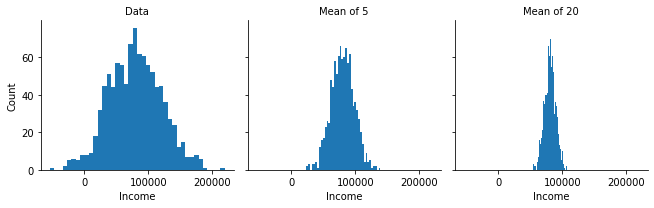

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt

full_data = norm.rvs(80000, 40000, 1000000)

sample_data = pd.DataFrame({
    'income': np.random.choice(full_data, 1000),
    'type': 'Data'
})
mof5 = pd.DataFrame({
    'income': [np.random.choice(full_data, 5).mean() for _ in range(1000)],
    'type':'Mean of 5'
})
mof20 = pd.DataFrame({
    'income': [np.random.choice(full_data, 20).mean() for _ in range(1000)],
    'type':'Mean of 20'
})
results = pd.concat([sample_data, mof5, mof20])

g = sns.FacetGrid(results, col='type')
g.map(plt.hist, 'income', bins=40)
g.set_axis_labels('Income', 'Count')
g.set_titles('{col_name}');

Plots show that:
- Data distribution has larger spread than sampling distributions
- The spread of sampling distributions decreases with increasing sample size

### Central limit theorem

- The second point above is an instance of the central limit theorem, which states that means from multiple samples are normally distributed even if the underlying distribution is not normal, provied that the sample size is large enough.

- More precisely: Suppose that we have a sequence of independent and identically distributed (iid) random variables $\{x_1, ..., x_n\}$ drawn from a distribution with expected value $\mu$ and finite variance given by $\sigma^2$, and we are interested in the mean value $\bar{x} = \frac{x_1 + ... + x_n}{n}$. By law of large numbers, $\bar{x}$ converges to $\mu$. The central limite theorem describes the shape of the random variation of $\bar{x}$ around $\mu$ during this convergence. In particular, for large enough $n$, the distribution of $\bar{x}$ will be close to a normal distribution with mean $\mu$ and standard deviation $\sigma/n$.

- This is useful because it means that irrespective of the underlying distribution (i.e. the distribution of the values in our sequence above), we can use the normal distribution and approximations to it (such as the t-distribution) to calculate sample distributions when we inference. Because of this, the CLT is at the heart of the theory of hypothesis testing and confidence intervals, and thus of much of classical statistics.

In [ ]:
from scipy.stats import binom, geom, poisson, norm, beta, expon, gamma


mu = 0
sigma = 2
n_sample = 1
n_draws = 1000

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# Normal
sample_means = [norm.rvs(mu, sigma, n_sample).mean() for _ in range(n_draws)]
x = np.linspace(sigma*-3, sigma*3, 100)
ax[0, 0].plot(x, norm.pdf(x, mu, sigma))
ax[0, 1].hist(sample_means, bins=40);

# Binomial
sample_means = [np.mean([binom.rvs(50, 0.5) for a in range(n_sample)]) for b in range(n_draws)]
x = np.arange(40)
ax[1, 0].bar(x, binom.pmf(x, 50, 0.5))
ax[1, 1].hist(sample_means, bins=40);

In [17]:
fig = plt.figure()


<Figure size 432x288 with 0 Axes>